In [1]:
import pandas as pd
import numpy as np
import os

In [ ]:
work_dir = os.environ.get("DART_WORK_DIR", "")

In [2]:
HEPG2_peaks = pd.read_csv(os.path.join(work_dir,"task_3_peak_classification/input_data/HEPG2/diff_acc_peaks.csv"))
HEPG2_peaks = HEPG2_peaks.rename(columns={"Unnamed: 0" : "peak"}).set_index("peak")
HEPG2_peaks = HEPG2_peaks.sort_values(by="padj", ascending=True)
HEPG2_peaks["significant"] = ["Significant"]*5000+["Not significant"]*(HEPG2_peaks.shape[0]-5000)

In [3]:
GM12878_peaks = pd.read_csv(os.path.join(work_dir,"task_3_peak_classification/input_data/GM12878/diff_acc_peaks.csv"))
GM12878_peaks = GM12878_peaks.rename(columns={"Unnamed: 0" : "peak"}).set_index("peak")
GM12878_peaks = GM12878_peaks.sort_values(by="padj", ascending=True)
GM12878_peaks["significant"] = ["Significant"]*5000+["Not significant"]*(GM12878_peaks.shape[0]-5000)

In [4]:
K562_peaks = pd.read_csv(os.path.join(work_dir,"task_3_peak_classification/input_data/K562/diff_acc_peaks.csv"))
K562_peaks = K562_peaks.rename(columns={"Unnamed: 0" : "peak"}).set_index("peak")
K562_peaks = K562_peaks.sort_values(by="padj", ascending=True)
K562_peaks["significant"] = ["Significant"]*5000+["Not significant"]*(K562_peaks.shape[0]-5000)

In [5]:
H1ESC_peaks =pd.read_csv(os.path.join(work_dir,"task_3_peak_classification/input_data/H1ESC/diff_acc_peaks.csv"))
H1ESC_peaks = H1ESC_peaks.rename(columns={"Unnamed: 0" : "peak"}).set_index("peak")
H1ESC_peaks = H1ESC_peaks.sort_values(by="padj", ascending=True)
H1ESC_peaks["significant"] = ["Significant"]*5000+["Not significant"]*(H1ESC_peaks.shape[0]-5000)

In [6]:
IMR90_peaks = pd.read_csv(os.path.join(work_dir,"task_3_peak_classification/input_data/IMR90/diff_acc_peaks.csv"))
IMR90_peaks = IMR90_peaks.rename(columns={"Unnamed: 0" : "peak"}).set_index("peak")
IMR90_peaks = IMR90_peaks.sort_values(by="padj", ascending=True)
IMR90_peaks["significant"] = ["Significant"]*5000+["Not significant"]*(IMR90_peaks.shape[0]-5000)

In [7]:
result = pd.concat([HEPG2_peaks,GM12878_peaks, K562_peaks, H1ESC_peaks, IMR90_peaks], axis=1, keys=['HEPG2', 'GM12878', "K562", "H1ESC", "IMR90"])

In [8]:
for df in [HEPG2_peaks,GM12878_peaks, K562_peaks, H1ESC_peaks, IMR90_peaks]:
    print(df[df["significant"]=="Significant"].shape[0])

5000
5000
5000
5000
5000


In [9]:
dfs = {
    'HEPG2': HEPG2_peaks,
    'GM12878': GM12878_peaks,
    'K562': K562_peaks,
    'H1ESC': H1ESC_peaks,
    'IMR90': IMR90_peaks
}

In [10]:
for key, df in dfs.items():
#     df = df.set_index('ID')
    df['significant'] = df['significant'].apply(lambda x: key if x == 'Significant' else None)
    dfs[key] = df[['significant']]  # We only keep the 'significant' column now

from functools import reduce
combined_df = reduce(lambda left, right: left.join(right, how='outer', rsuffix='_right'), dfs.values())
combined_df.columns = dfs.keys()  # Rename columns to DataFrame labels

combined_df['overlapping_dfs'] = combined_df.apply(lambda row: list(filter(None, row)), axis=1)

combined_df['overlap_count'] = combined_df['overlapping_dfs'].apply(len)

In [11]:
import pandas as pd
from upsetplot import UpSet
from collections import Counter
import matplotlib.pyplot as plt

# Convert the list of DataFrames into a Series of frozensets
set_series = combined_df['overlapping_dfs'].apply(frozenset)

# Count the frozensets
set_counts = Counter(set_series)

set_counts

Counter({frozenset(): 191745,
         frozenset({'HEPG2'}): 5000,
         frozenset({'GM12878'}): 5000,
         frozenset({'IMR90'}): 5000,
         frozenset({'K562'}): 5000,
         frozenset({'H1ESC'}): 5000})

In [13]:
cell_by_peaks = combined_df[combined_df["overlap_count"]>0][["overlapping_dfs", "overlap_count"]].copy(deep=True)

In [14]:
set_counts

Counter({frozenset(): 191745,
         frozenset({'HEPG2'}): 5000,
         frozenset({'GM12878'}): 5000,
         frozenset({'IMR90'}): 5000,
         frozenset({'K562'}): 5000,
         frozenset({'H1ESC'}): 5000})

<Figure size 1440x360 with 0 Axes>

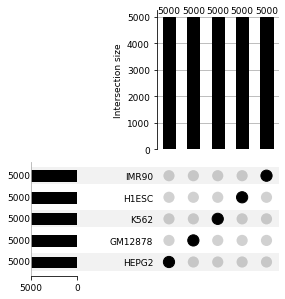

In [15]:
datasets = ['HEPG2', 'GM12878', 'K562', 'H1ESC', 'IMR90']

from itertools import product
all_combinations = list(product([False, True], repeat=len(datasets)))
multi_index = pd.MultiIndex.from_tuples(all_combinations, names=datasets)

# Create the Series
data_series = pd.Series(index=multi_index, dtype=int).fillna(0)  # Start with zero counts

# Map each frozenset to the appropriate index tuple and accumulate counts
for comb, count in set_counts.items():
    index_tuple = tuple(d in comb for d in datasets)
    data_series[index_tuple] += count  # Increment the count for each combination

# Ensure non-zero entries are present
# Plot using UpSet
plt.figure(figsize=(20, 5))
plt.tight_layout() 
plt.rcParams.update({'font.size': 9})  
upset = UpSet(data_series[data_series > 0], subset_size='sum', show_counts=True, max_subset_size="40%")
upset.plot()

plt.show()

In [16]:
new_df = pd.DataFrame(columns=["Peaks", "Cell Type"])
for cell_type in datasets:
    print(cell_type)
    mask = cell_by_peaks['overlapping_dfs'].apply(lambda x: cell_type in x)
    df = cell_by_peaks[mask]
    df = df[df["overlap_count"]==1]
    print(df.shape)
    df.index.names = [cell_type + " Peaks"]
    new_df = pd.concat([new_df,pd.DataFrame({"Peaks" : list(df.index), "Cell Type" : [cell_type]*len(df.index)})])
    print(new_df.shape)

HEPG2
(5000, 2)
(5000, 2)
GM12878
(5000, 2)
(10000, 2)
K562
(5000, 2)
(15000, 2)
H1ESC
(5000, 2)
(20000, 2)
IMR90
(5000, 2)
(25000, 2)


In [17]:
new_df[["Chr", "Coords"]] = new_df["Peaks"].str.split(":", expand=True)
new_df[["Start", "End"]] = new_df["Coords"].str.split("-", expand=True)
new_df = new_df[["Chr", "Start", "End", "Cell Type"]]

In [18]:
new_df.to_csv(os.path.join(work_dir,f"task_3_peak_classification/input_data/{cell_type}/top_5000_deseq_peaks.tsv"), 
              sep="\t", index=False)